[INFO] Loaded X shape = (296, 39)
[INFO] Columns: ['b1', 'b2', 'p1', 'p2', 'p3', 'p4', 'sss', 'sst', 'Fe', 'PP', 'Si', 'NO3', 'CHL', 'PHYC', 'PO4', 'O2', 'vgosa', 'vgos', 'sla', 'ugosa', 'ugos', 'wind_stress', 'eastward_wind', 'surface_downward_eastward_stress', 'wind_speed', 'surface_downward_northward_stress', 'northward_wind', 'ftle_bw_sla', 'disp_bw_sla', 'AOU_WOA_clim', 'density_WOA_clim', 'o2sat_WOA_clim', 'oxygen_WOA_clim', 'salinity_WOA_clim', 'conductivity_WOA_clim', 'nitrate_WOA_clim', 'phosphate_WOA_clim', 'silicate_WOA_clim', 'par']


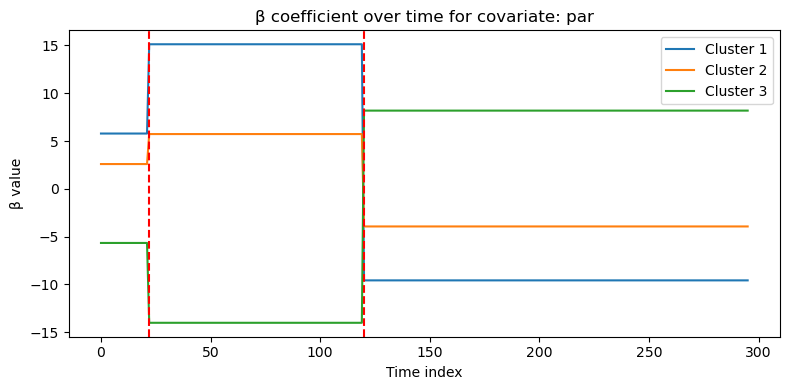

[INFO] X_repeat shape = (296, 100, 37) (T=296, N=100, P=37)


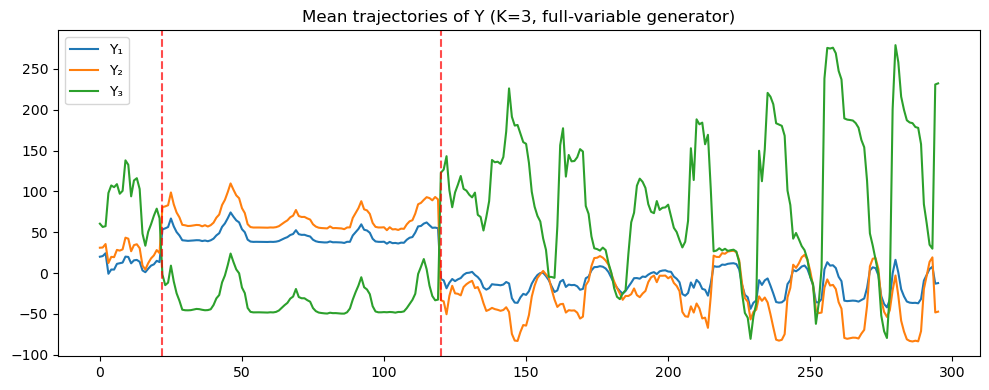

In [25]:
import torch
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
from cpd_model import parse_args, evaluation, learn_one_seq_penalty, CPD, mixture_of_gaussians_loss
from data_generator import generate_x, generate_gmm_data_segments, softmax
import io, sys, warnings
import numpy as np
import pandas as pd
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"


import numpy as np
import pandas as pd
from scipy.special import softmax
import pyreadr
import matplotlib.pyplot as plt

# ======================================================
# 1. Load X (RDS DataFrame)
# ======================================================
result = pyreadr.read_r("realx.RDS")  
X_df = list(result.values())[0]
print(f"[INFO] Loaded X shape = {X_df.shape}")
print(f"[INFO] Columns: {list(X_df.columns)}")
pos1 = np.where(X_df["b1"].values == 1)[0][0]
pos2 = np.where(X_df["b2"].values == 1)[0][0]
true_cp = [pos1, pos2]


# ======================================================
# 2. General generator using all features except b1,b2
# ======================================================
def generate_Y_from_realX(X_df, n_rep=100, sigma=0.3, seed=77):
    """
    Generate Y_t ~ sum_k pi_{k,t} N(X_t β_k + β_{k0}, σ² I)
    - Use all columns in X_df except b1, b2
    - 'par' dominates in β_k (large coefficients)
    - Cluster probabilities depend on other covariates (not par)
    - β changes across segments defined by b1,b2
    - K = 3 clusters, 3D response (stronger inter-dim differences)
    """
    np.random.seed(seed)

    # Identify changepoints
    pos1 = np.where(X_df["b1"].values == 1)[0][0]
    pos2 = np.where(X_df["b2"].values == 1)[0][0]
    true_cp = [pos1, pos2]

    # Extract usable covariates
    covariate_cols = [c for c in X_df.columns if c not in ["b1", "b2"]]
    if "par" not in covariate_cols:
        raise ValueError("Column 'par' must be in X_df to construct dominant effect.")

    X_use = X_df[covariate_cols].to_numpy()
    n, p = X_use.shape
    par_idx = covariate_cols.index("par")

    K, D = 3, 3
    cov_shared = np.eye(D) * sigma**2
    segments = [range(0, pos1), range(pos1, pos2), range(pos2, n)]

    # --------------------------------------------------
    # Segment-specific β_k (bigger par jumps for seg1→seg2)
    # --------------------------------------------------
    betas_segments = []
    for seg_id in range(3):
        β = []
        for k in range(K):
            base = np.random.uniform(-0.3, 0.3, size=p)
            # par effect (dominant, varies sharply for seg1→seg2)
            if seg_id == 0:
                base[par_idx] = np.random.uniform(4, 6) * (1 if k == 0 else (-1 if k == 2 else 0.5))
            elif seg_id == 1:
                base[par_idx] = np.random.uniform(12, 16) * (1 if k == 0 else (-1 if k == 2 else 0.4))  # stronger jump
            else:
                base[par_idx] = np.random.uniform(-10, -8) * (1 if k == 0 else (-1 if k == 2 else 0.4))
            β.append(base)
        betas_segments.append(β)

    # --------------------------------------------------
    # Stronger offsets per dimension (β₀ jump in Y₁/Y₂ at pos1)
    # --------------------------------------------------
    β0_segments = []
    for seg_id in range(3):
        β0s = []
        for k in range(K):
            if seg_id == 0:
                β0 = np.array([5*k, 8*k + np.random.uniform(-2,2), 20*k + np.random.uniform(-3,3)])
            elif seg_id == 1:
                β0 = np.array([20*k + np.random.uniform(-5,5), 25*k + np.random.uniform(-6,6), -5*k + np.random.uniform(-3,3)])  # amplified for Y₁/Y₂
            else:
                β0 = np.array([-5*k + np.random.uniform(-3,3), -10*k + np.random.uniform(-3,3), 25*k + np.random.uniform(-5,5)])
            β0s.append(β0)
        β0_segments.append(β0s)

    # --------------------------------------------------
    # Cluster weights depend only on non-par covariates
    # --------------------------------------------------
    X_wo_par = np.delete(X_use, par_idx, axis=1)
    A = np.random.randn(X_wo_par.shape[1], K) * 0.3 + np.random.uniform(-1, 1, size=(X_wo_par.shape[1], K))

    # --------------------------------------------------
    # Generate Y
    # --------------------------------------------------
    Y = np.zeros((n, n_rep, D))
    comp_label = np.zeros((n, n_rep), dtype=int)
    dim_scale = np.array([2.0, 3.0, 4.0])  # amplify dimension differences (slightly boost Y₁/Y₂)

    for seg_id, seg_range in enumerate(segments):
        betas = betas_segments[seg_id]
        beta0s = β0_segments[seg_id]

        for i in seg_range:
            x_t = X_use[i]
            logits = X_wo_par[i] @ A
            pis = softmax(logits)
            ks = np.random.choice(K, size=n_rep, p=pis)
            comp_label[i, :] = ks

            for j in range(n_rep):
                k = ks[j]
                mean = (x_t @ betas[k] + beta0s[k]) * dim_scale
                Y[i, j, :] = np.random.multivariate_normal(mean, cov_shared)

    return Y, comp_label, true_cp, betas_segments, β0_segments

import matplotlib.pyplot as plt

def visualize_betas_over_time(betas_segments, X_df, true_cp, target_covs=None):
    """
    Plot β coefficients (per covariate) for each mixture component across segments.
    """
    K = len(betas_segments[0])
    p = len(betas_segments[0][0])
    covariate_cols = [c for c in X_df.columns if c not in ["b1", "b2"]]
    
    if target_covs is None:
        target_covs = ["par"] 
    
    # Build segment index boundaries
    pos1 = np.where(X_df["b1"].values == 1)[0][0]
    pos2 = np.where(X_df["b2"].values == 1)[0][0]
    segments = [(0, pos1), (pos1, pos2), (pos2, len(X_df))]
    
    for cov in target_covs:
        cov_idx = covariate_cols.index(cov)
        plt.figure(figsize=(8,4))
        for k in range(K):
            beta_values = []
            time_axis = []
            for seg_id, (start, end) in enumerate(segments):
                val = betas_segments[seg_id][k][cov_idx]
                beta_values += [val]*(end - start)
                time_axis += list(range(start, end))
            plt.plot(time_axis, beta_values, label=f"Cluster {k+1}")
        for cp in true_cp:
            plt.axvline(cp, color='r', linestyle='--', lw=1.5)
        plt.title(f"β coefficient over time for covariate: {cov}")
        plt.xlabel("Time index")
        plt.ylabel("β value")
        plt.legend()
        plt.tight_layout()
        plt.show()






# ======================================================
# 3. Visualization
# ======================================================
def visualize_Y_mean(Y, true_cp):
    mean_Y = Y.mean(axis=1)
    plt.figure(figsize=(10,4))
    plt.plot(mean_Y[:,0], label='Y₁')
    plt.plot(mean_Y[:,1], label='Y₂')
    plt.plot(mean_Y[:,2], label='Y₃')
    for cp in true_cp:
        plt.axvline(cp, color='r', linestyle='--', alpha=0.7)
    plt.title("Mean trajectories of Y (K=3, full-variable generator)")
    plt.legend()
    plt.tight_layout()
    plt.show()



# ======================================================
# 4. Run + visualize
# ======================================================

nrep = 100

Y, comp_label, true_cp, betas_segments, β0_segments = generate_Y_from_realX(X_df, n_rep=nrep, sigma=0.3, seed=123)

visualize_betas_over_time(betas_segments, X_df, true_cp, target_covs=["par"])

def repeat_X_3d(X_df, n_rep=100):
    """
    Drop columns ['b1','b2'] and repeat X into shape (T, n_rep, p)
    """
    # Drop b1, b2
    X_cov = X_df.drop(columns=["b1", "b2"])
    X_mat = X_cov.to_numpy()  # (T, p)
    T, p = X_mat.shape

    # Repeat along sample axis
    X_repeat = np.repeat(X_mat[:, None, :], n_rep, axis=1)  # (T, n_rep, p)
    print(f"[INFO] X_repeat shape = {X_repeat.shape} (T={T}, N={n_rep}, P={p})")

    return X_repeat
X_repeat = repeat_X_3d(X_df, n_rep=nrep)
X = X_repeat
X_repeat.shape

visualize_Y_mean(Y, true_cp=true_cp)




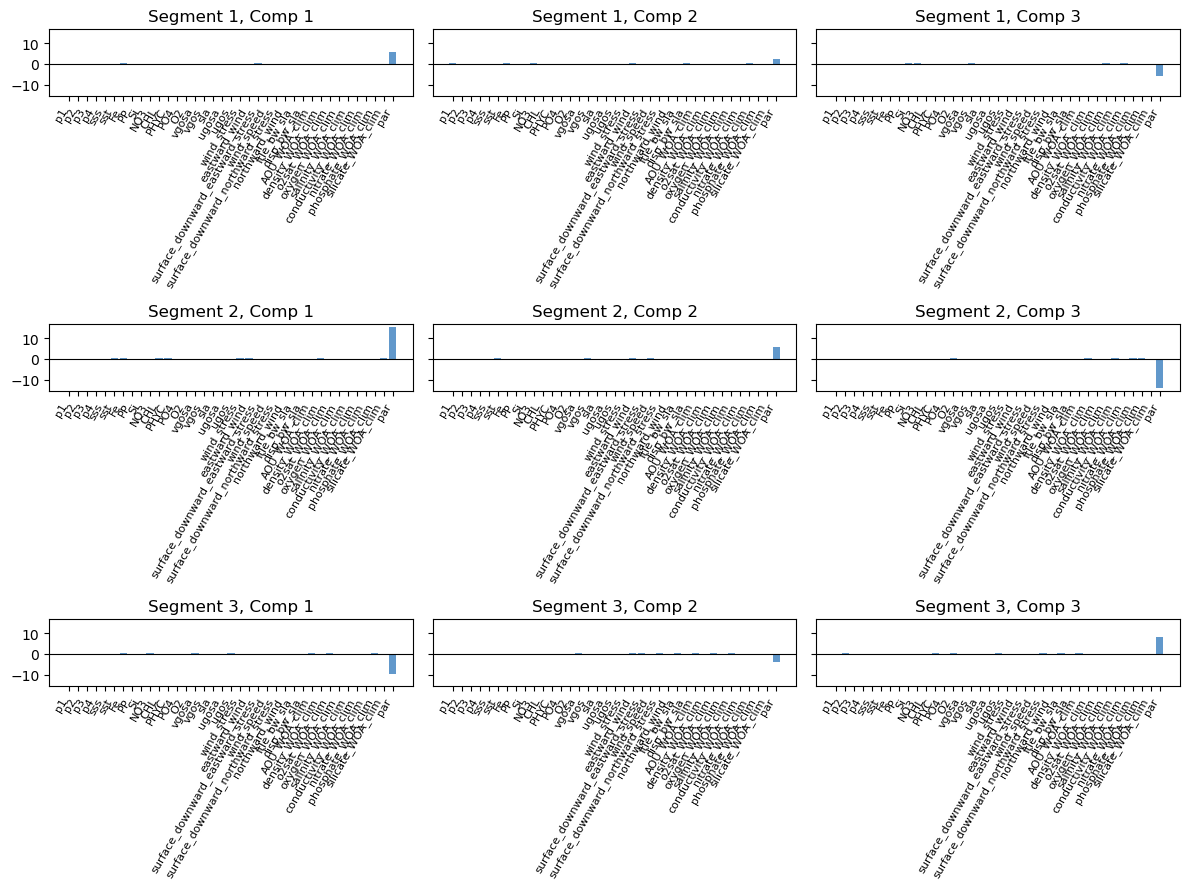

In [26]:
import matplotlib.pyplot as plt
import numpy as np


covariate_cols = [c for c in X_df.columns if c not in ["b1", "b2"]]
seg_num = len(betas_segments)
K = len(betas_segments[0])
p = len(covariate_cols)

fig, axes = plt.subplots(seg_num, K, figsize=(4*K, 3*seg_num), sharey=True)

for seg_id in range(seg_num):
    for k in range(K):
        ax = axes[seg_id, k] if seg_num > 1 else axes[k]
        beta_vals = betas_segments[seg_id][k]
        ax.bar(np.arange(p), beta_vals, color="#3A7EBF", alpha=0.8)
        ax.set_xticks(np.arange(p))
        ax.set_xticklabels(covariate_cols, rotation=60, ha="right", fontsize=8)
        ax.set_title(f"Segment {seg_id+1}, Comp {k+1}")
        ax.axhline(0, color='black', lw=0.8)
plt.tight_layout()
plt.show()


[INFO] Using device: cuda
Epoch   5 | Loss=6949.216797 | Accuracy=0.3258 | Averaged=False
Epoch  10 | Loss=6576.548828 | Accuracy=0.4369 | Averaged=False
Epoch  15 | Loss=6434.011719 | Accuracy=0.3378 | Averaged=False


KeyboardInterrupt: 

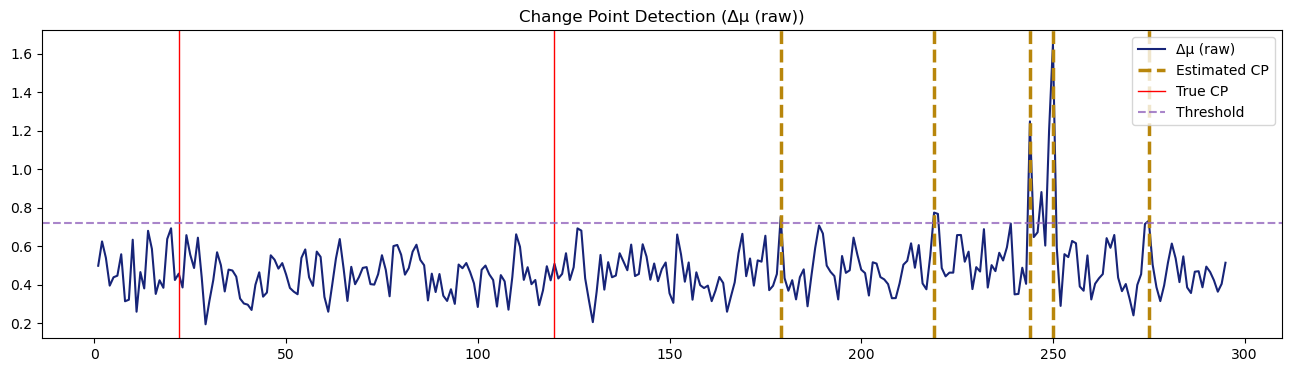

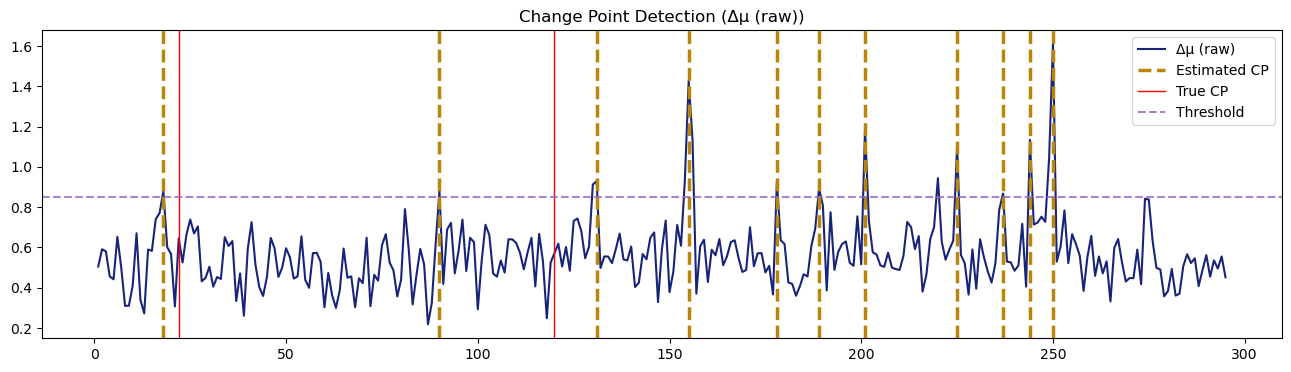

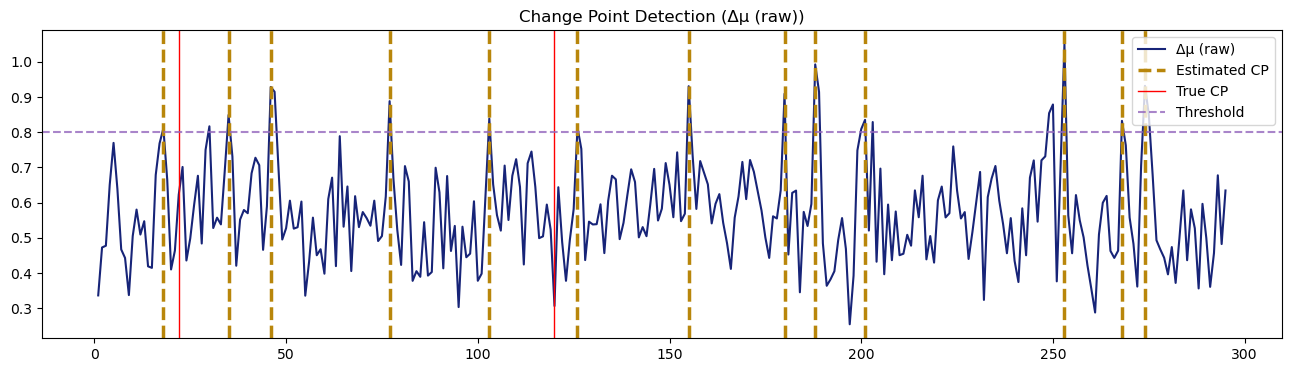

In [27]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

rep_id = 0

args = parse_args()
args.epoch = 40
args.z_dim = 10
args.x_dim = X.shape[2]
args.y_dim = Y.shape[2]
args.num_time = X.shape[0]
args.num_samples = X.shape[1]
args.decoder_lr = 0.0002
args.decoder_iteration = 100
args.langevin_s = 0.15
args.langevin_K = 200
args.kappa = 0.3
args.penalties = [10]
args.nu_iteration = 100
args.output_layer = [300, 300]
args.scale_y = False
args.scale_delta = False
args.signif_level = 0.95
args.true_CP_full = true_cp

X_flat = X.reshape(-1, args.x_dim)
X_mean, X_std = X_flat.mean(axis=0, keepdims=True), X_flat.std(axis=0, keepdims=True) + 1e-8
X_flat = (X_flat - X_mean) / X_std
X_array = X_flat.reshape(args.num_time, -1, args.x_dim)

x_input = torch.tensor(X_array, dtype=torch.float32).to(device)
y_input = torch.tensor(Y.reshape(args.num_time, -1, args.y_dim), dtype=torch.float32).to(device)

# Split train/test for penalty selection
odd_idx, even_idx = range(1, args.num_time, 2), range(0, args.num_time, 2)
x_train, x_test = x_input[odd_idx].reshape(-1, args.x_dim), x_input[even_idx].reshape(-1, args.x_dim)
y_train, y_test = y_input[odd_idx].reshape(-1, args.y_dim), y_input[even_idx].reshape(-1, args.y_dim)

# ---------- Penalty selection ----------
# results_half = []
# for penalty in args.penalties:
#     _stdout = sys.stdout
#     sys.stdout = io.StringIO()
#     try:
#         loss, pen = learn_one_seq_penalty(args, x_train, y_train, x_test, y_test, penalty=penalty, half=True)
#     finally:
#         sys.stdout = _stdout
#     results_half.append([loss, pen])

# results_half = np.array(results_half)
# best_idx = np.argmin(results_half[:, 0])
# best_penalty = args.penalties[best_idx]
# print(f"[INFO] rep={rep_id}, best_penalty={best_penalty}")

# ---------- Full training using best penalty ----------
res = learn_one_seq_penalty(args, x_input.reshape(-1, args.x_dim), y_input.reshape(-1, args.y_dim), x_input.reshape(-1, args.x_dim), y_input.reshape(-1, args.y_dim), penalty=args.penalties[0], half=False)
torch.cuda.empty_cache()
